<a href="https://colab.research.google.com/github/xanasa14/Finances/blob/main/Heikin_Ashi_backtest_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#https://github.com/je-suis-tm/quant-trading/blob/master/Heikin-Ashi%20backtest.py

#heikin ashi is a Japanese way to filter out the noise for momentum trading
#it can prevent the occurrence of sideway chops
#basically we do a few transformations on four key benchmarks - Open, Close, High, Low
#apply some unique rules on ha Open, Close, High, Low to trade
#details of heikin ashi indicators and rules can be found in the following link
# https://quantiacs.com/Blog/Intro-to-Algorithmic-Trading-with-Heikin-Ashi.aspx

#need to get yfinance package first
#it changes its name from fix_yahoo_finance to yfinance, lol
!pip install yfinance
!pip install yahoofinancials


     |████████████████████████████████| 6.3 MB 6.5 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15190 sha256=981a5a5d10e3ef7e390a1b4766f79a308012ae541e19a87c7ebf537cd718e379
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials


In [16]:
# In[2]:


import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from yahoofinancials import YahooFinancials
import numpy as np
import scipy.integrate
import scipy.stats



In [17]:
#Heikin Ashi has a unique method to filter out the noise
#its open, close, high, low require a different approach
#please refer to the website mentioned above
def heikin_ashi(data):
    
    df=data.copy()
    
    df.reset_index(inplace=True)
        
    #heikin ashi close
    df['HA close']=(df['Open']+df['Close']+df['High']+df['Low'])/4

    #initialize heikin ashi open
    df['HA open']=float(0)
    df['HA open'][0]=df['Open'][0]

    #heikin ashi open
    for n in range(1,len(df)):
        df.at[n,'HA open']=(df['HA open'][n-1]+df['HA close'][n-1])/2
        
    #heikin ashi high/low
    temp=pd.concat([df['HA open'],df['HA close'],df['Low'],df['High']],axis=1)
    df['HA high']=temp.apply(max,axis=1)
    df['HA low']=temp.apply(min,axis=1)

    del df['Adj Close']
    del df['Volume']
    
    return df

In [18]:
#setting up signal generations
#trigger conditions can be found from the website mentioned above
#they kinda look like marubozu candles
#there s a short strategy as well
#the trigger condition of short strategy is the reverse of long strategy
#you have to satisfy all four conditions to long/short
#nevertheless, the exit signal only has three conditions
def signal_generation(df,method,stls):
        
    data=method(df)
    
    data['signals']=0

    #i use cumulated sum to check how many positions i have longed
    #i would ignore the exit signal prior if not holding positions
    #i also keep tracking how many long positions i have got
    #long signals cannot exceed the stop loss limit
    data['cumsum']=0

    for n in range(1,len(data)):
        
        #long triggered
        if (data['HA open'][n]>data['HA close'][n] and data['HA open'][n]==data['HA high'][n] and
            np.abs(data['HA open'][n]-data['HA close'][n])>np.abs(data['HA open'][n-1]-data['HA close'][n-1]) and
            data['HA open'][n-1]>data['HA close'][n-1]):
            
            data.at[n,'signals']=1
            data['cumsum']=data['signals'].cumsum()


            #accumulate too many longs
            if data['cumsum'][n]>stls:
                data.at[n,'signals']=0
        
        #exit positions
        elif (data['HA open'][n]<data['HA close'][n] and data['HA open'][n]==data['HA low'][n] and 
        data['HA open'][n-1]<data['HA close'][n-1]):
            
            data.at[n,'signals']=-1
            data['cumsum']=data['signals'].cumsum()
        

            #clear all longs
            #if there are no long positions in my portfolio
            #ignore the exit signal
            if data['cumsum'][n]>0:
                data.at[n,'signals']=-1*(data['cumsum'][n-1])

            if data['cumsum'][n]<0:
                data.at[n,'signals']=0
                
    return data

In [19]:
#since matplotlib remove the candlestick
#plus we dont wanna install mpl_finance
#we implement our own version
#simply use fill_between to construct the bar
#use line plot to construct high and low
def candlestick(df,ax=None,titlename='',highcol='High',lowcol='Low',
                opencol='Open',closecol='Close',xcol='Date',
                colorup='r',colordown='g',**kwargs):  
    
    #bar width
    #use 0.6 by default
    dif=[(-3+i)/10 for i in range(7)]
    
    if not ax:
        ax=plt.figure(figsize=(10,5)).add_subplot(111)
    
    #construct the bars one by one
    for i in range(len(df)):
        
        #width is 0.6 by default
        #so 7 data points required for each bar
        x=[i+j for j in dif]
        y1=[df[opencol].iloc[i]]*7
        y2=[df[closecol].iloc[i]]*7

        barcolor=colorup if y1[0]>y2[0] else colordown
        
        #no high line plot if open/close is high
        if df[highcol].iloc[i]!=max(df[opencol].iloc[i],df[closecol].iloc[i]):
            
            #use generic plot to viz high and low
            #use 1.001 as a scaling factor
            #to prevent high line from crossing into the bar
            plt.plot([i,i],
                     [df[highcol].iloc[i],
                      max(df[opencol].iloc[i],
                          df[closecol].iloc[i])*1.001],c='k',**kwargs)
    
        #same as high
        if df[lowcol].iloc[i]!=min(df[opencol].iloc[i],df[closecol].iloc[i]):             
            
            plt.plot([i,i],
                     [df[lowcol].iloc[i],
                      min(df[opencol].iloc[i],
                          df[closecol].iloc[i])*0.999],c='k',**kwargs)
        
        #treat the bar as fill between
        plt.fill_between(x,y1,y2,
                         edgecolor='k',
                         facecolor=barcolor,**kwargs)

    #only show 5 xticks
    plt.xticks(range(0,len(df),len(df)//5),df[xcol][0::len(df)//5].dt.date)
    plt.title(titlename)
    
    
#plotting the backtesting result
def plot(df,ticker):    
    
    df.set_index(df['Date'],inplace=True)
    
    #first plot is Heikin-Ashi candlestick
    #use candlestick function and set Heikin-Ashi O,C,H,L
    ax1=plt.subplot2grid((200,1), (0,0), rowspan=120,ylabel='HA price')
    candlestick(df,ax1,titlename='',highcol='HA high',lowcol='HA low',
                opencol='HA open',closecol='HA close',xcol='Date',
                colorup='r',colordown='g')
    plt.grid(True)
    plt.xticks([])
    plt.title('Heikin-Ashi')


    #the second plot is the actual price with long/short positions as up/down arrows
    ax2=plt.subplot2grid((200,1), (120,0), rowspan=80,ylabel='price',xlabel='')
    df['Close'].plot(ax=ax2,label=ticker)

    #long/short positions are attached to the real close price of the stock
    #set the line width to zero
    #thats why we only observe markers
    ax2.plot(df.loc[df['signals']==1].index,df['Close'][df['signals']==1],marker='^',lw=0,c='g',label='long')
    ax2.plot(df.loc[df['signals']<0].index,df['Close'][df['signals']<0],marker='v',lw=0,c='r',label='short')

    plt.grid(True)
    plt.legend(loc='best')
    plt.show()


In [20]:
#backtesting
#initial capital 10k to calculate the actual pnl  
#100 shares to buy of every position
def portfolio(data,capital0=10000,positions=100):   
        
    #cumsum column is created to check the holding of the position
    data['cumsum']=data['signals'].cumsum()

    portfolio=pd.DataFrame()
    portfolio['holdings']=data['cumsum']*data['Close']*positions
    portfolio['cash']=capital0-(data['signals']*data['Close']*positions).cumsum()
    portfolio['total asset']=portfolio['holdings']+portfolio['cash']
    portfolio['return']=portfolio['total asset'].pct_change()
    portfolio['signals']=data['signals']
    portfolio['date']=data['Date']
    portfolio.set_index('date',inplace=True)

    return portfolio



In [21]:
#plotting the asset value change of the portfolio
def profit(portfolio):
        
    fig=plt.figure()
    bx=fig.add_subplot(111)
    
    portfolio['total asset'].plot(label='Total Asset')
    
    #long/short position markers related to the portfolio
    #the same mechanism as the previous one
    #replace close price with total asset value
    bx.plot(portfolio['signals'].loc[portfolio['signals']==1].index,portfolio['total asset'][portfolio['signals']==1],lw=0,marker='^',c='g',label='long')
    bx.plot(portfolio['signals'].loc[portfolio['signals']<0].index,portfolio['total asset'][portfolio['signals']<0],lw=0,marker='v',c='r',label='short')
    
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Asset Value')
    plt.title('Total Asset')
    plt.show()

In [22]:
#omega ratio is a variation of sharpe ratio
#the risk free return is replaced by a given threshold
#in this case, the return of benchmark
#integral is needed to calculate the return above and below the threshold
#you can use summation to do approximation as well
#it is a more reasonable ratio to measure the risk adjusted return
#normal distribution doesnt explain the fat tail of returns
#so i use student T cumulated distribution function instead 
#to make our life easier, i do not use empirical distribution
#the cdf of empirical distribution is much more complex
#check wikipedia for more details
# https://en.wikipedia.org/wiki/Omega_ratio
def omega(risk_free,degree_of_freedom,maximum,minimum):

    y=scipy.integrate.quad(lambda g:1-scipy.stats.t.cdf(g,degree_of_freedom),risk_free,maximum)
    x=scipy.integrate.quad(lambda g:scipy.stats.t.cdf(g,degree_of_freedom),minimum,risk_free)

    z=(y[0])/(x[0])

    return z


#sortino ratio is another variation of sharpe ratio
#the standard deviation of all returns is substituted with standard deviation of negative returns
#sortino ratio measures the impact of negative return on return
#i am also using student T probability distribution function instead of normal distribution
#check wikipedia for more details
# https://en.wikipedia.org/wiki/Sortino_ratio
def sortino(risk_free,degree_of_freedom,growth_rate,minimum):

    v=np.sqrt(np.abs(scipy.integrate.quad(lambda g:((risk_free-g)**2)*scipy.stats.t.pdf(g,degree_of_freedom),risk_free,minimum)))
    s=(growth_rate-risk_free)/v[0]

    return s


#i use a function to calculate maximum drawdown
#the idea is simple
#for every day, we take the current asset value marked to market
#to compare with the previous highest asset value
#we get our daily drawdown
#it is supposed to be negative if the current one is not the highest
#we implement a temporary variable to store the minimum negative value
#which is called maximum drawdown
#for each daily drawdown that is smaller than our temporary value
#we update the temp until we finish our traversal
#in the end we return the maximum drawdown
def mdd(series):

    minimum=0
    for i in range(1,len(series)):
        if minimum>(series[i]/max(series[:i])-1):
            minimum=(series[i]/max(series[:i])-1)

    return minimum


In [23]:
#stats calculation
def stats(portfolio,trading_signals,stdate,eddate,capital0=10000):

    stats=pd.DataFrame([0])

    #get the min and max of return
    maximum=np.max(portfolio['return'])
    minimum=np.min(portfolio['return'])    

    #growth_rate denotes the average growth rate of portfolio 
    #use geometric average instead of arithmetic average for percentage growth
    growth_rate=(float(portfolio['total asset'].iloc[-1]/capital0))**(1/len(trading_signals))-1

    #calculating the standard deviation
    std=float(np.sqrt((((portfolio['return']-growth_rate)**2).sum())/len(trading_signals)))

    #use S&P500 as benchmark
    benchmark=yf.download('^GSPC',start=stdate,end=eddate)

    #return of benchmark
    return_of_benchmark=float(benchmark['Close'].iloc[-1]/benchmark['Open'].iloc[0]-1)

    #rate_of_benchmark denotes the average growth rate of benchmark 
    #use geometric average instead of arithmetic average for percentage growth
    rate_of_benchmark=(return_of_benchmark+1)**(1/len(trading_signals))-1

    del benchmark

    #backtesting stats
    #CAGR stands for cumulated average growth rate
    stats['CAGR']=stats['portfolio return']=float(0)
    stats['CAGR'][0]=growth_rate
    stats['portfolio return'][0]=portfolio['total asset'].iloc[-1]/capital0-1
    stats['benchmark return']=return_of_benchmark
    stats['sharpe ratio']=(growth_rate-rate_of_benchmark)/std
    stats['maximum drawdown']=mdd(portfolio['total asset'])

    #calmar ratio is sorta like sharpe ratio
    #the standard deviation is replaced by maximum drawdown
    #it is the measurement of return after worse scenario adjustment
    #check wikipedia for more details
    # https://en.wikipedia.org/wiki/Calmar_ratio
    stats['calmar ratio']=growth_rate/stats['maximum drawdown']
    stats['omega ratio']=omega(rate_of_benchmark,len(trading_signals),maximum,minimum)
    stats['sortino ratio']=sortino(rate_of_benchmark,len(trading_signals),growth_rate,minimum)

    #note that i use stop loss limit to limit the numbers of longs
    #and when clearing positions, we clear all the positions at once
    #so every long is always one, and short cannot be larger than the stop loss limit
    stats['numbers of longs']=trading_signals['signals'].loc[trading_signals['signals']==1].count()
    stats['numbers of shorts']=trading_signals['signals'].loc[trading_signals['signals']<0].count()
    stats['numbers of trades']=stats['numbers of shorts']+stats['numbers of longs']  

    #to get the total length of trades
    #given that cumsum indicates the holding of positions
    #we can get all the possible outcomes when cumsum doesnt equal zero
    #then we count how many non-zero positions there are
    #we get the estimation of total length of trades
    stats['total length of trades']=trading_signals['signals'].loc[trading_signals['cumsum']!=0].count()
    stats['average length of trades']=stats['total length of trades']/stats['numbers of trades']
    stats['profit per trade']=float(0)
    stats['profit per trade'].iloc[0]=(portfolio['total asset'].iloc[-1]-capital0)/stats['numbers of trades'].iloc[0]

    del stats[0]
    print(stats)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


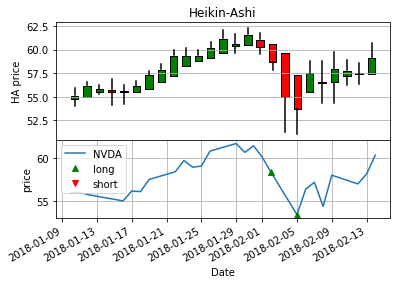

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


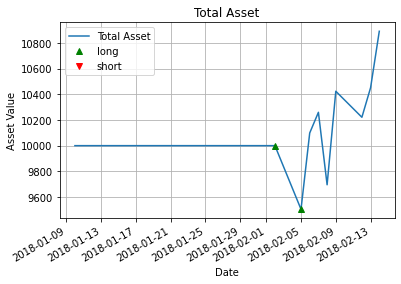

[*********************100%***********************]  1 of 1 completed
       CAGR  portfolio return  ...  average length of trades  profit per trade
0  0.000118           0.08905  ...                  2.365591          9.575268

[1 rows x 14 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [24]:


#stop loss positions, the maximum long positions we can get
#without certain constraints, you will long indefinites times 
#as long as the market condition triggers the signal
#in a whipsaw condition, it is suicidal
stls=3
ticker='NVDA'
stdate='2015-04-01'
eddate='2018-02-15'

#slicer is used for plotting
#a three year dataset with 750 data points would be too much
slicer=700

#downloading data
df=yf.download(ticker,start=stdate,end=eddate)

trading_signals=signal_generation(df,heikin_ashi,stls)

viz=trading_signals[slicer:]
plot(viz,ticker)

portfolio_details=portfolio(viz)
profit(portfolio_details)

stats(portfolio_details,trading_signals,stdate,eddate)

#note that this is the only py file with complete stats calculation

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


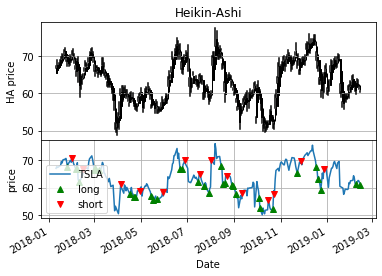

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


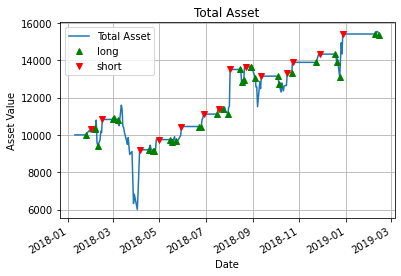

[*********************100%***********************]  1 of 1 completed
      CAGR  portfolio return  ...  average length of trades  profit per trade
0  0.00044           0.53614  ...                  2.720588         39.422077

[1 rows x 14 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [25]:
#stop loss positions, the maximum long positions we can get
#without certain constraints, you will long indefinites times 
#as long as the market condition triggers the signal
#in a whipsaw condition, it is suicidal
stls=3
ticker='TSLA'
stdate='2015-04-01'
eddate='2019-02-15'

#slicer is used for plotting
#a three year dataset with 750 data points would be too much
slicer=700

#downloading data
df=yf.download(ticker,start=stdate,end=eddate)

trading_signals=signal_generation(df,heikin_ashi,stls)

viz=trading_signals[slicer:]
plot(viz,ticker)

portfolio_details=portfolio(viz)
profit(portfolio_details)

stats(portfolio_details,trading_signals,stdate,eddate)

#note that this is the only py file with complete stats calculati

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


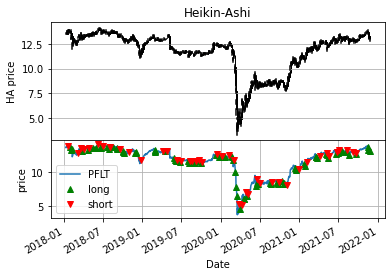

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


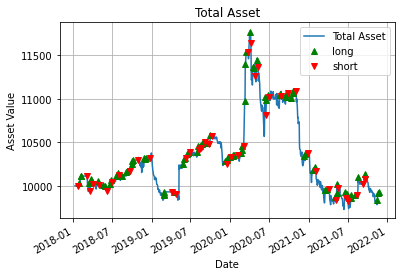

[*********************100%***********************]  1 of 1 completed
       CAGR  portfolio return  ...  average length of trades  profit per trade
0 -0.000004           -0.0069  ...                  3.455446         -0.341583

[1 rows x 14 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [26]:


#stop loss positions, the maximum long positions we can get
#without certain constraints, you will long indefinites times 
#as long as the market condition triggers the signal
#in a whipsaw condition, it is suicidal
stls=3
ticker='PFLT'
stdate='2015-04-01'
eddate='2021-11-28'

#slicer is used for plotting
#a three year dataset with 750 data points would be too much
slicer=700

#downloading data
df=yf.download(ticker,start=stdate,end=eddate)

trading_signals=signal_generation(df,heikin_ashi,stls)

viz=trading_signals[slicer:]
plot(viz,ticker)

portfolio_details=portfolio(viz)
profit(portfolio_details)

stats(portfolio_details,trading_signals,stdate,eddate)

#note that this is the only py file with complete stats calculation